## PIMA INDIANS DIABETES DATASET

Check Spark version

In [0]:
spark

**1. Import Libraries/Dataset**

1 a.	Download the dataset

In [0]:
%fs ls /FileStore/tables/diabetes.csv

path,name,size,modificationTime
dbfs:/FileStore/tables/diabetes.csv,diabetes.csv,23873,1710599407000


In [0]:
# 1 b.	Import the required libraries

from pyspark.sql import SparkSession, SQLContext, DataFrameNaFunctions
from pyspark.sql.types import *
from pyspark.sql.functions import skewness, mean, median, when, col, exp, sum
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.stat import Correlation
from pyspark.ml.linalg import Vectors
from pyspark.ml.tuning import TrainValidationSplit
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, GBTClassifier, NaiveBayes, DecisionTreeClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics

import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

**2. Data Visualization and Exploration**

In [0]:
# Initialise Spark Session
if __name__ == "__main__":
    spark = SparkSession \
        .builder \
        .appName("SPA Assignment") \
        .config("spark.streaming.stopGracefullyOnShutdown", "true") \
        .config("spark.sql.shuffle.partitions", 3) \
        .getOrCreate()

In [0]:
# Create schema for the dataset

schema = StructType([
  StructField("Pregnancies", ByteType(), False),
  StructField("Glucose", ShortType(), False),
  StructField("BloodPressure", ByteType(), False),
  StructField("SkinThickness", IntegerType(), False),
  StructField("Insulin", IntegerType(), False),
  StructField("BMI", DoubleType(), False),
  StructField("DiabetesPedigreeFunction", DoubleType(), False),
  StructField("Age", ByteType(), False),
  StructField("Outcome", ByteType(), False)
])

In [0]:
# Create Spark Data Frame with the schema defined above and the file downloaded.
sdf = spark.read.option("header","true").format("csv").schema(schema).load("/FileStore/tables/diabetes.csv")
cols = sdf.columns
cols

['Pregnancies',
 'Glucose',
 'BloodPressure',
 'SkinThickness',
 'Insulin',
 'BMI',
 'DiabetesPedigreeFunction',
 'Age',
 'Outcome']

2 a.	Print at least 5 rows for sanity check to identify all the features present in the dataset and if the target matches with them.

In [0]:
display(sdf)

Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
6,148,72,35,0,33.6,0.627,50,1
1,85,66,29,0,26.6,0.351,31,0
8,183,64,0,0,23.3,0.672,32,1
1,89,66,23,94,28.1,0.167,21,0
0,137,40,35,168,43.1,2.288,33,1
5,116,74,0,0,25.6,0.201,30,0
3,78,50,32,88,31.0,0.248,26,1
10,115,0,0,0,35.3,0.134,29,0
2,197,70,45,543,30.5,0.158,53,1
8,125,96,0,0,0.0,0.232,54,1


In [0]:
sdf.show(5)

+-----------+-------+-------------+-------------+-------+----+------------------------+---+-------+
|Pregnancies|Glucose|BloodPressure|SkinThickness|Insulin| BMI|DiabetesPedigreeFunction|Age|Outcome|
+-----------+-------+-------------+-------------+-------+----+------------------------+---+-------+
|          6|    148|           72|           35|      0|33.6|                   0.627| 50|      1|
|          1|     85|           66|           29|      0|26.6|                   0.351| 31|      0|
|          8|    183|           64|            0|      0|23.3|                   0.672| 32|      1|
|          1|     89|           66|           23|     94|28.1|                   0.167| 21|      0|
|          0|    137|           40|           35|    168|43.1|                   2.288| 33|      1|
+-----------+-------+-------------+-------------+-------+----+------------------------+---+-------+
only showing top 5 rows



2 b.	Print the description and shape of the dataset.

In [0]:
# Description
sdf.describe().show

# Checking the schema
sdf.printSchema()

root
 |-- Pregnancies: byte (nullable = true)
 |-- Glucose: short (nullable = true)
 |-- BloodPressure: byte (nullable = true)
 |-- SkinThickness: integer (nullable = true)
 |-- Insulin: integer (nullable = true)
 |-- BMI: double (nullable = true)
 |-- DiabetesPedigreeFunction: double (nullable = true)
 |-- Age: byte (nullable = true)
 |-- Outcome: byte (nullable = true)



In [0]:
# Print shape of the DataFrame

print("DataFrame Shape:")
print("Rows:", sdf.count())
print("Columns:", len(cols))

DataFrame Shape:
Rows: 768
Columns: 9


In [0]:
#Print count of each category - Diabetic or Non-Diabetic

sdf.toPandas().groupby(['Outcome']).size()

Outcome
0    500
1    268
dtype: int64

2 c.	Provide appropriate visualization to get an insight about the dataset.

Text(0.5, 1.0, 'Outcome')

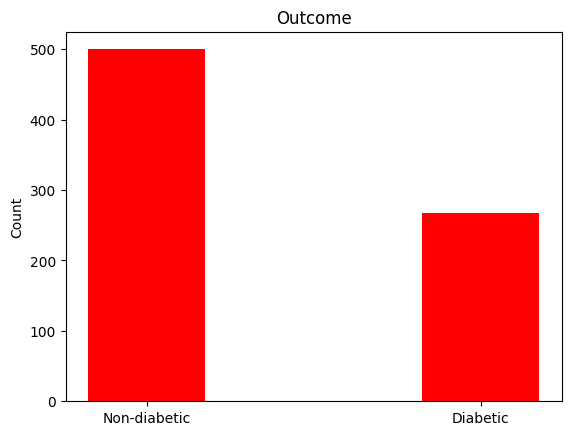

In [0]:
#Plotting a histogram with matplotlib to visualize the count of each category 

outcomes = sdf.groupBy('Outcome').count().collect()
categories = [i[0] for i in outcomes]
counts = [i[1] for i in outcomes]
ind = ['Non-diabetic','Diabetic']
width = 0.35
plt.bar(ind, counts, width=width, color='r')
plt.ylabel('Count')
plt.title('Outcome')


Utilising DataBricks SQL and Visualization

In [0]:
sdf.createOrReplaceTempView("pima_indian_diabetes")

In [0]:
%sql
select Pregnancies,
 Glucose,
 BloodPressure,
 SkinThickness,
 Insulin,
 BMI,
 DiabetesPedigreeFunction,
 Age,
 Outcome from pima_indian_diabetes;

Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
6,148,72,35,0,33.6,0.627,50,1
1,85,66,29,0,26.6,0.351,31,0
8,183,64,0,0,23.3,0.672,32,1
1,89,66,23,94,28.1,0.167,21,0
0,137,40,35,168,43.1,2.288,33,1
5,116,74,0,0,25.6,0.201,30,0
3,78,50,32,88,31.0,0.248,26,1
10,115,0,0,0,35.3,0.134,29,0
2,197,70,45,543,30.5,0.158,53,1
8,125,96,0,0,0.0,0.232,54,1


Databricks visualization. Run in Databricks to view.

In [0]:
%sql
select min(Insulin), max(Insulin), mean(Insulin), median(Insulin), Outcome from pima_indian_diabetes
 group by Outcome;

min(Insulin),max(Insulin),mean(Insulin),median(Insulin),Outcome
0,744,68.792,39.0,0
0,846,100.33582089552239,0.0,1


From the dataset visualization, we realize that around 35% of patients have diabetes.

**3.	Data Pre-processing and cleaning**

3 a.	Do the appropriate preprocessing of the data like identifying NULL or Missing Values if any, handling of outliers if present in the dataset, skewed data etc. Apply appropriate feature engineering techniques for them.


In [0]:
# Check for missing values in each column
missing_values = sdf.select(*(sum(col(c).isNull().cast("int")).alias(c) for c in sdf.columns))

# Count total missing values in the DataFrame
total_missing_values = missing_values.collect()[0]

# Display the total missing values
print("Total missing values:")
for col_name, missing_count in zip(sdf.columns, total_missing_values):
    print(col_name + ": " + str(missing_count))


Total missing values:
Pregnancies: 0
Glucose: 0
BloodPressure: 0
SkinThickness: 0
Insulin: 0
BMI: 0
DiabetesPedigreeFunction: 0
Age: 0
Outcome: 0


There are no columns with missing values in this dataset. However, in this dataset, there are a lot of outliers and medically impossible values (such as 0 for BMI, glucose, bloodpressure etc.). This being a small dataset, the effect of such outliers will be huge, we will replace the 0 values with median as a first step.

In [0]:
sdf.select(cols).describe().toPandas().transpose()

,0,1,2,3,4
summary,count,mean,stddev,min,max
Pregnancies,768,3.8450520833333335,3.36957806269887,0,17
Glucose,768,120.89453125,31.97261819513622,0,199
BloodPressure,768,69.10546875,19.355807170644777,0,122
SkinThickness,768,20.536458333333332,15.952217567727642,0,99
Insulin,768,79.79947916666667,115.24400235133803,0,846
BMI,768,31.992578124999977,7.884160320375441,0.0,67.1
DiabetesPedigreeFunction,768,0.4718763020833327,0.331328595012775,0.078,2.42
Age,768,33.240885416666664,11.760231540678689,21,81
Outcome,768,0.3489583333333333,0.476951377242799,0,1


*The minimum values for Glucose, BloodPressure, SkinThickness, Insulin, and BMI are 0, which is not valid. Let us see an outlier analysis for this data with box plots.*

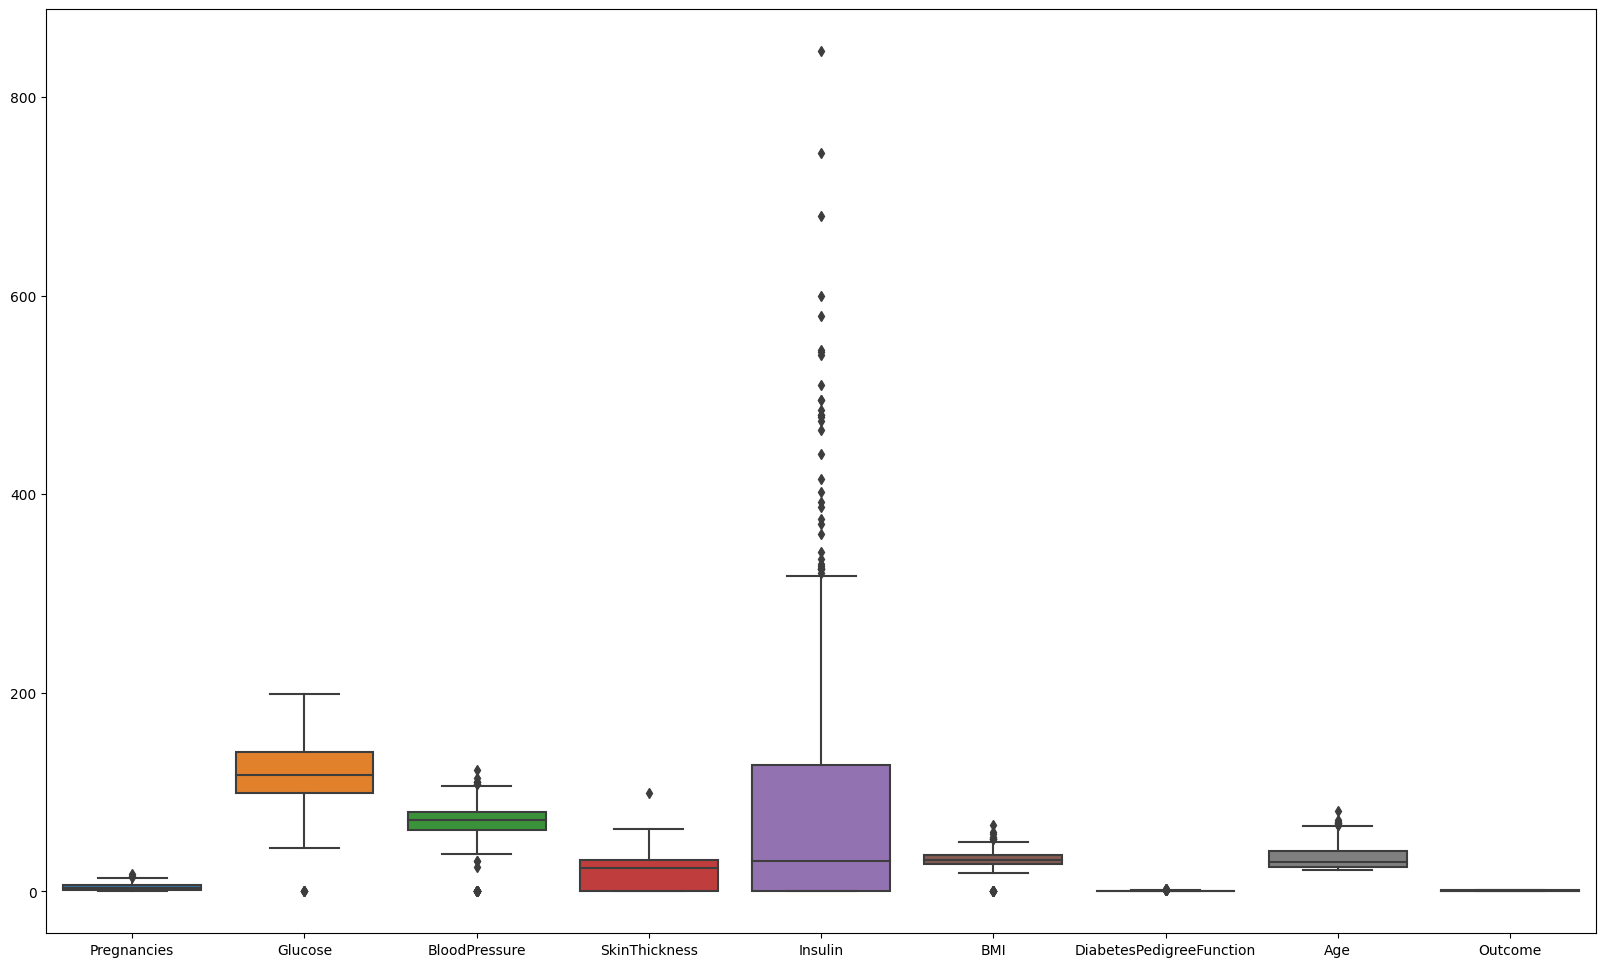

In [0]:
plt.figure(figsize=[20,12])
sns.boxplot(data=sdf.toPandas())
plt.show()

In [0]:
feature_columns = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']
target_column='Outcome'

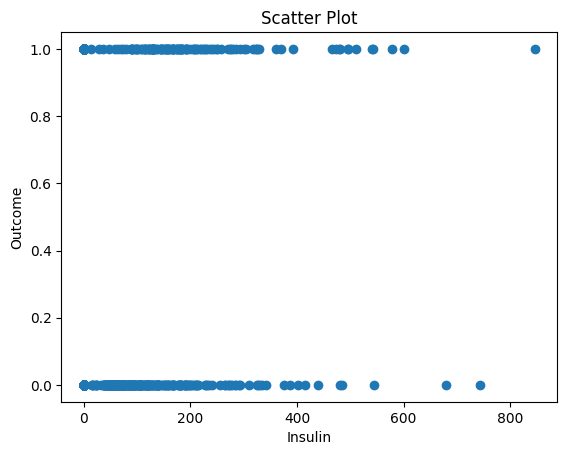

In [0]:
# Convert Spark DataFrame to Pandas DataFrame
pandas_df = sdf.toPandas()

# Plot the scatter plot using Matplotlib
plt.scatter(pandas_df['Insulin'], pandas_df['Outcome'])
plt.xlabel('Insulin')
plt.ylabel('Outcome')
plt.title("Scatter Plot")
plt.show()

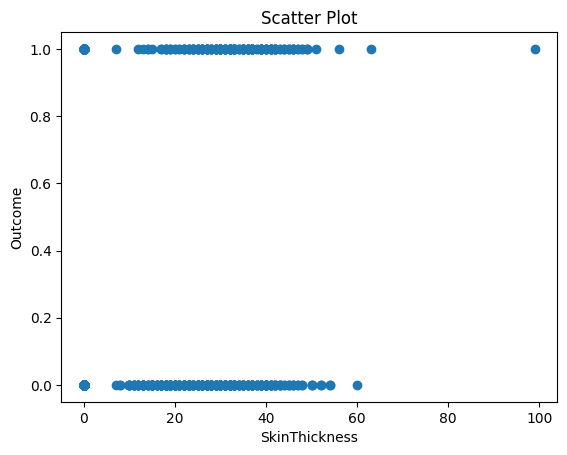

In [0]:
# Plot the scatter plot using Matplotlib
plt.scatter(pandas_df['SkinThickness'], pandas_df['Outcome'])
plt.xlabel('SkinThickness')
plt.ylabel('Outcome')
plt.title("Scatter Plot")
plt.show()

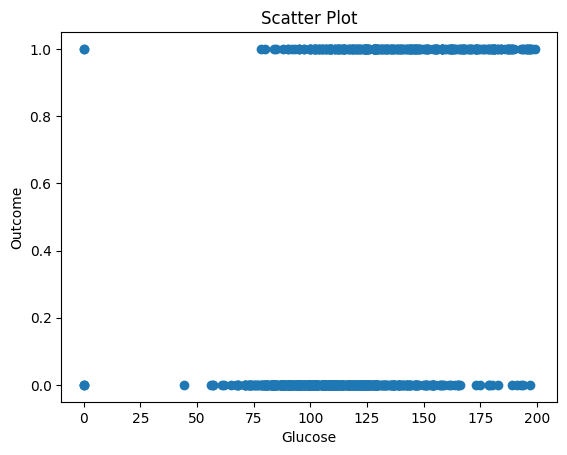

In [0]:
# Plot the scatter plot using Matplotlib
plt.scatter(pandas_df['Glucose'], pandas_df['Outcome'])
plt.xlabel('Glucose')
plt.ylabel('Outcome')
plt.title("Scatter Plot")
plt.show()

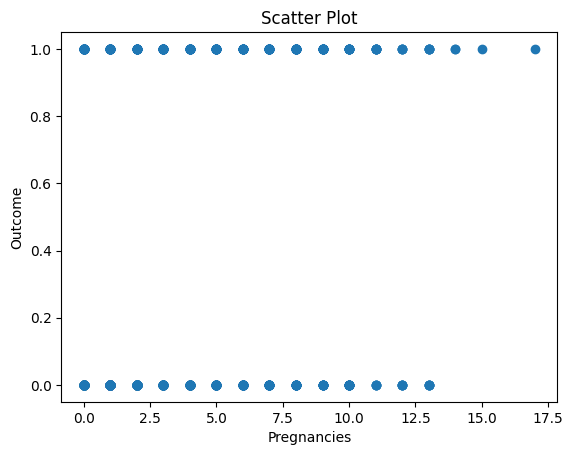

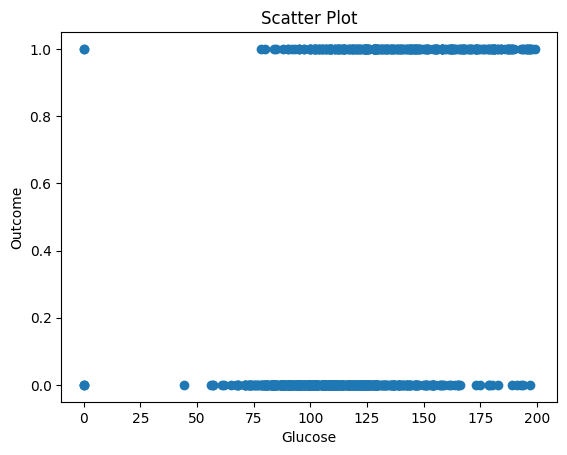

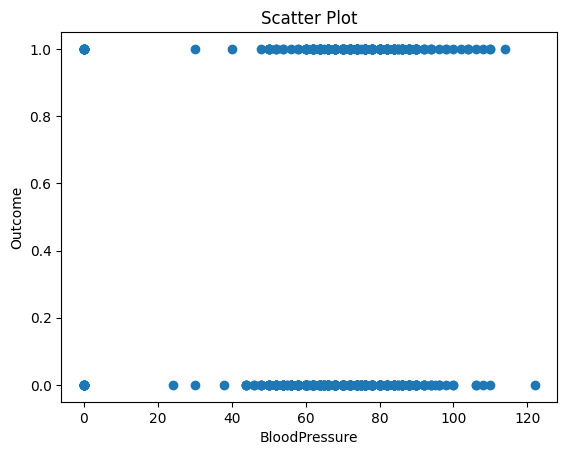

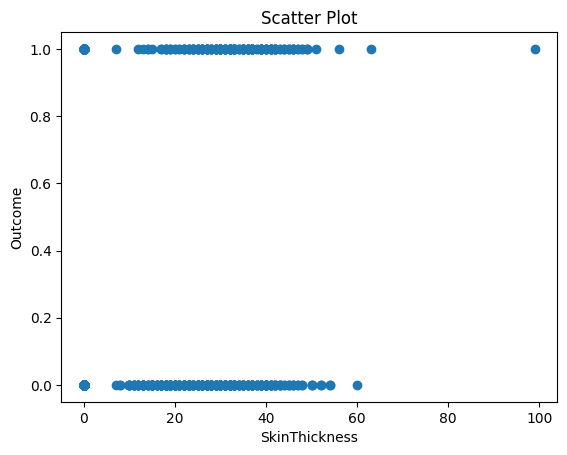

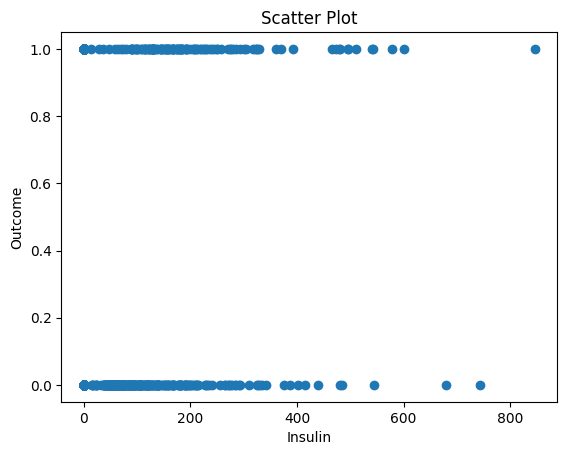

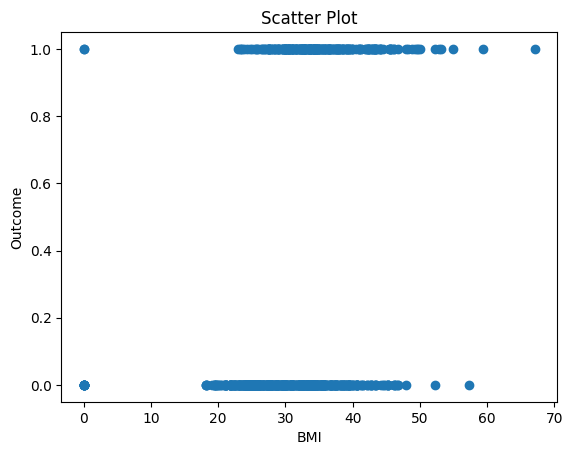

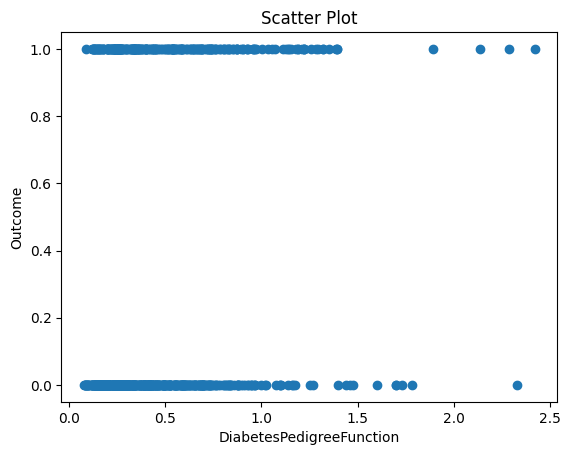

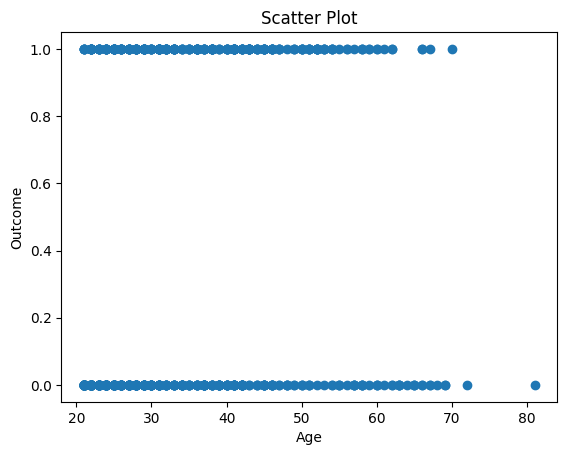

In [0]:
def sdf_scatterplot():
    # Assuming 'feature' is the name of the feature column
    for feature in feature_columns :
        #feature_values = sdf.select(str(feature)).rdd.flatMap(lambda x: x).collect()
        # Plot scatter plot
        plt.scatter(pandas_df[feature], pandas_df['Outcome'])
        plt.xlabel(feature)
        plt.ylabel('Outcome')
        plt.title("Scatter Plot")
        plt.show()
sdf_scatterplot()

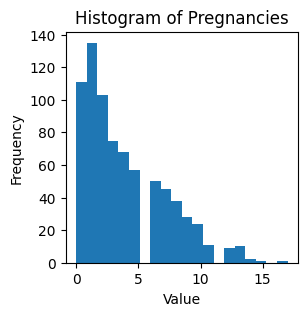

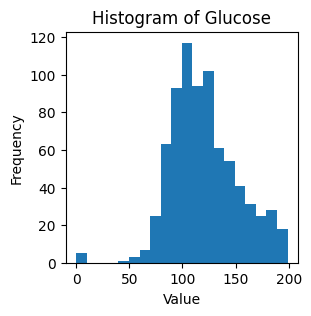

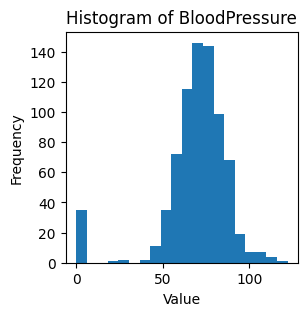

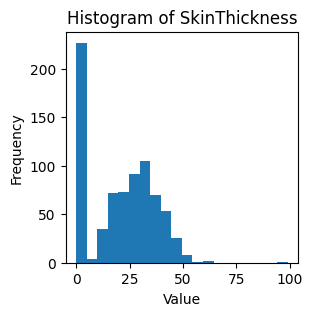

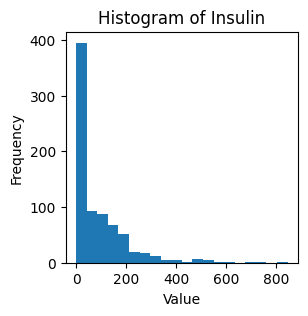

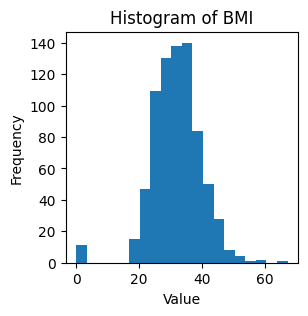

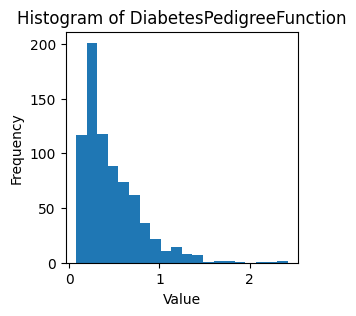

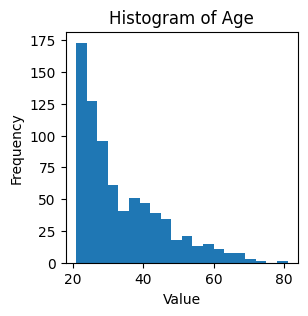

In [0]:
def sdf_histogram():
    # Assuming 'feature' is the name of the feature column
    for feature in feature_columns :
        feature_values = sdf.select(str(feature)).rdd.flatMap(lambda x: x).collect()
        # Plot histogram
        plt.figure(figsize=(3,3))
        plt.hist(feature_values, bins=20)
        plt.title('Histogram of '+str(feature))
        plt.xlabel('Value')
        plt.ylabel('Frequency')
        plt.show()

sdf_histogram()

In [0]:
# Compute skewness for numeric columns
skewness_sdf = sdf.select([skewness(col).alias(col) for col in sdf.columns if col != 'Outcome'])

# Show the skewness
display(skewness_sdf)

Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
0.8999119408414356,0.1734139551998773,-1.8400052311728723,0.10915876232367273,2.2678104585131846,-0.42814327880861847,1.9161592037386226,1.127389259531697


Considering both the plots above and the skewness values, we can infer that Glucose, and SkinThickness are almost normally distributed. There are too many 0 values in  BloodPressure which cause the positive skewness, however the plot resembles normal distribution if we disregard those 0s.
Let us replace the 0 values wherever necessary with mean or median values as applicable.

In [0]:
#Handling 0 values

# Calculate the mean or median for each column
means = sdf.agg(*(mean(col).alias(col) for col in sdf.columns))
medians = sdf.agg(*(median(col).alias(col) for col in sdf.columns))

# Replace zero values with mean or median for each column
for col in sdf.columns:
    #sdf = sdf.withColumn(col, when(sdf[col] == 0, means.first()[col]).otherwise(sdf[col])) if col in ['Glucose','SkinThickness'] else sdf
    #sdf = sdf.withColumn(col, when(sdf[col] == 0, medians.first()[col]).otherwise(sdf[col])) if col in ['BloodPressure', 'Insulin', 'BMI'] else sdf
    sdf = sdf.withColumn(col, when(sdf[col] == 0, medians.first()[col]).otherwise(sdf[col])) if col in feature_columns else sdf



In [0]:
display(sdf)

Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
6.0,148.0,72.0,35.0,30.5,33.6,0.627,50.0,1
1.0,85.0,66.0,29.0,30.5,26.6,0.351,31.0,0
8.0,183.0,64.0,23.0,30.5,23.3,0.672,32.0,1
1.0,89.0,66.0,23.0,94.0,28.1,0.167,21.0,0
3.0,137.0,40.0,35.0,168.0,43.1,2.288,33.0,1
5.0,116.0,74.0,23.0,30.5,25.6,0.201,30.0,0
3.0,78.0,50.0,32.0,88.0,31.0,0.248,26.0,1
10.0,115.0,72.0,23.0,30.5,35.3,0.134,29.0,0
2.0,197.0,70.0,45.0,543.0,30.5,0.158,53.0,1
8.0,125.0,96.0,23.0,30.5,32.0,0.232,54.0,1


In [0]:
# Compute skewness for numeric columns
skewness_sdf = sdf.select([skewness(col).alias(col) for col in sdf.columns if col != 'Outcome'])

# Show the skewness
display(skewness_sdf)

Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
1.109622183621841,0.5345406664125956,0.14160775043921198,1.2206670365618888,2.6879177380345536,0.5998841409874487,1.9161592037386226,1.127389259531697


The skewness seems to have improved now. 

Let us get a box plot again to see the outliers now.

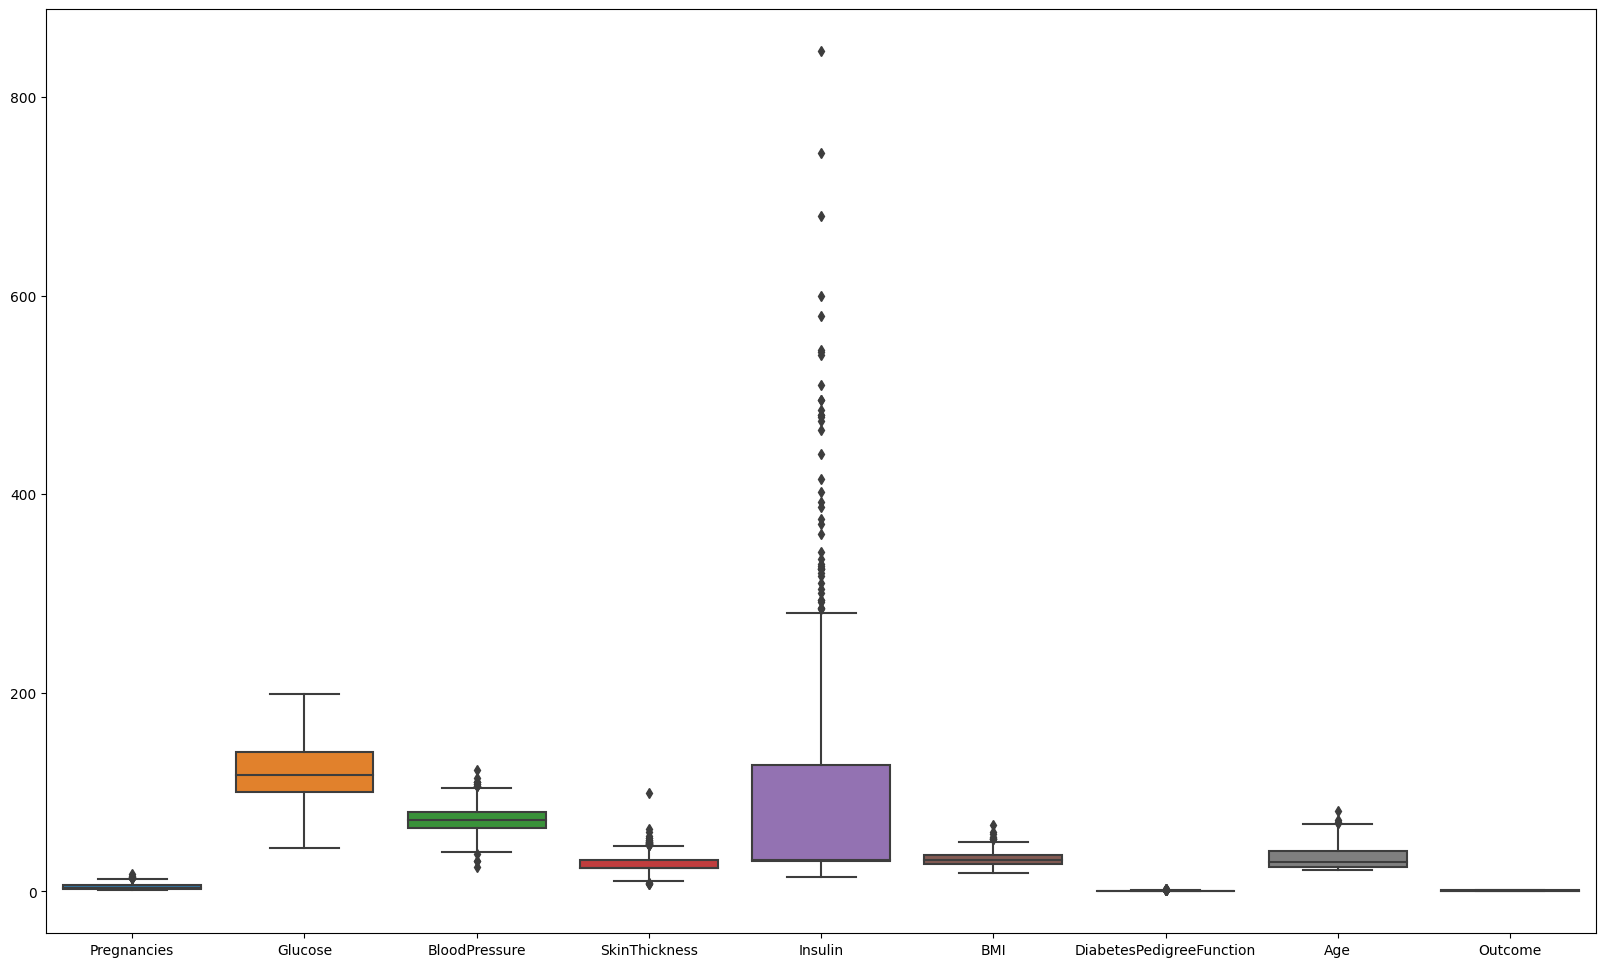

In [0]:
plt.figure(figsize=[20,12])
sns.boxplot(data=sdf.toPandas(), whis=1.6 )
plt.show()

In [0]:
from pyspark.sql import functions as F

def iqr_outlier_treatment(sdf, column, factor=1.5):
    # Calculate Q1, Q3, and IQR
    quantiles = sdf.approxQuantile(column, [0.25, 0.75], 0.01)
    q1, q3 = quantiles[0], quantiles[1]
    iqr = q3 - q1

    # Define the upper and lower bounds for outliers
    lower_bound = q1 - factor * iqr
    upper_bound = q3 + factor * iqr

    # Filter outliers and update the DataFrame
    #sdf = sdf.filter((col(column) >= lower_bound) & (col(column) <= upper_bound))

    sdf = sdf.filter(F.col("Insulin").between(lower_bound, upper_bound))

    return sdf


# We have the most outliers in Insulin which we will try to treat. The outliers in the other features are important to the model as they may represent some valid special cases.
sdf = iqr_outlier_treatment(sdf, 'Insulin', factor=1.5)
display(sdf)


Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
6.0,148.0,72.0,35.0,30.5,33.6,0.627,50.0,1
1.0,85.0,66.0,29.0,30.5,26.6,0.351,31.0,0
8.0,183.0,64.0,23.0,30.5,23.3,0.672,32.0,1
1.0,89.0,66.0,23.0,94.0,28.1,0.167,21.0,0
3.0,137.0,40.0,35.0,168.0,43.1,2.288,33.0,1
5.0,116.0,74.0,23.0,30.5,25.6,0.201,30.0,0
3.0,78.0,50.0,32.0,88.0,31.0,0.248,26.0,1
10.0,115.0,72.0,23.0,30.5,35.3,0.134,29.0,0
8.0,125.0,96.0,23.0,30.5,32.0,0.232,54.0,1
4.0,110.0,92.0,23.0,30.5,37.6,0.191,30.0,0


3 b.	Apply the feature transformation techniques like Standardization, Normalization, etc. You are free to apply the appropriate transformations depending upon the structure and the complexity of your dataset.

**Standardization**

Insulin, Glucose, BloodPressure has a wide range of values. We will need to scale them using Standardization.
Standardization scales features to have a mean of 0 and a standard deviation of 1. Here, we have chosent it as it is less sensitive to outliers compared to normalization techniques like min-max scaling. This is crucial for small datasets where a single outlier can significantly impact the scaling range in normalization.

In [0]:
# Columns to be standardized
input_cols = ['Glucose', 'BloodPressure', 'Insulin']  

# Assemble the features into a single vector column
assembler = VectorAssembler(inputCols=input_cols, outputCol="features")
assembled_df = assembler.transform(sdf)

# Initialize the StandardScaler transformer
scaler = StandardScaler(inputCol="features", outputCol="scaled_features", withMean=True, withStd=True)

# Fit and transform the data
scaled_df = scaler.fit(assembled_df).transform(assembled_df)

# Show the scaled features
scaled_df.select("scaled_features").show(truncate=False)
display(scaled_df)

+---------------------------------------------------------------+
|scaled_features                                                |
+---------------------------------------------------------------+
|[0.9878455550902371,-0.03372796765659054,-0.7079580365417812]  |
|[-1.1672974754287389,-0.5282513432631167,-0.7079580365417812]  |
|[2.1851472387118904,-0.6930924684652922,-0.7079580365417812]   |
|[-1.03046299730055,-0.5282513432631167,0.3593547855753585]     |
|[0.6115507402377175,-2.671185970891397,1.6031524050504504]     |
|[-0.10683026993527446,0.13111315754558484,-0.7079580365417812] |
|[-1.4067578121530695,-1.8469803448805198,0.25850632994224293]  |
|[-0.14103888946732168,-0.03372796765659054,-0.7079580365417812]|
|[0.20104730585315067,1.9443655347695141,-0.7079580365417812]   |
|[-0.31208198712755786,1.6146832843651633,-0.7079580365417812]  |
|[1.6720179457311817,0.13111315754558484,-0.7079580365417812]   |
|[0.679967979301812,0.625636533152111,-0.7079580365417812]      |
|[1.603600

Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,features,scaled_features
6.0,148.0,72.0,35.0,30.5,33.6,0.627,50.0,1,"Map(vectorType -> dense, length -> 3, values -> List(148.0, 72.0, 30.5))","Map(vectorType -> dense, length -> 3, values -> List(0.9878455550902371, -0.03372796765659054, -0.7079580365417812))"
1.0,85.0,66.0,29.0,30.5,26.6,0.351,31.0,0,"Map(vectorType -> dense, length -> 3, values -> List(85.0, 66.0, 30.5))","Map(vectorType -> dense, length -> 3, values -> List(-1.1672974754287389, -0.5282513432631167, -0.7079580365417812))"
8.0,183.0,64.0,23.0,30.5,23.3,0.672,32.0,1,"Map(vectorType -> dense, length -> 3, values -> List(183.0, 64.0, 30.5))","Map(vectorType -> dense, length -> 3, values -> List(2.1851472387118904, -0.6930924684652922, -0.7079580365417812))"
1.0,89.0,66.0,23.0,94.0,28.1,0.167,21.0,0,"Map(vectorType -> dense, length -> 3, values -> List(89.0, 66.0, 94.0))","Map(vectorType -> dense, length -> 3, values -> List(-1.03046299730055, -0.5282513432631167, 0.3593547855753585))"
3.0,137.0,40.0,35.0,168.0,43.1,2.288,33.0,1,"Map(vectorType -> dense, length -> 3, values -> List(137.0, 40.0, 168.0))","Map(vectorType -> dense, length -> 3, values -> List(0.6115507402377175, -2.671185970891397, 1.6031524050504504))"
5.0,116.0,74.0,23.0,30.5,25.6,0.201,30.0,0,"Map(vectorType -> dense, length -> 3, values -> List(116.0, 74.0, 30.5))","Map(vectorType -> dense, length -> 3, values -> List(-0.10683026993527446, 0.13111315754558484, -0.7079580365417812))"
3.0,78.0,50.0,32.0,88.0,31.0,0.248,26.0,1,"Map(vectorType -> dense, length -> 3, values -> List(78.0, 50.0, 88.0))","Map(vectorType -> dense, length -> 3, values -> List(-1.4067578121530695, -1.8469803448805198, 0.25850632994224293))"
10.0,115.0,72.0,23.0,30.5,35.3,0.134,29.0,0,"Map(vectorType -> dense, length -> 3, values -> List(115.0, 72.0, 30.5))","Map(vectorType -> dense, length -> 3, values -> List(-0.14103888946732168, -0.03372796765659054, -0.7079580365417812))"
8.0,125.0,96.0,23.0,30.5,32.0,0.232,54.0,1,"Map(vectorType -> dense, length -> 3, values -> List(125.0, 96.0, 30.5))","Map(vectorType -> dense, length -> 3, values -> List(0.20104730585315067, 1.9443655347695141, -0.7079580365417812))"
4.0,110.0,92.0,23.0,30.5,37.6,0.191,30.0,0,"Map(vectorType -> dense, length -> 3, values -> List(110.0, 92.0, 30.5))","Map(vectorType -> dense, length -> 3, values -> List(-0.31208198712755786, 1.6146832843651633, -0.7079580365417812))"


3 c.	Do the correlational analysis on the dataset. Provide a visualization for the same.

<Axes: >

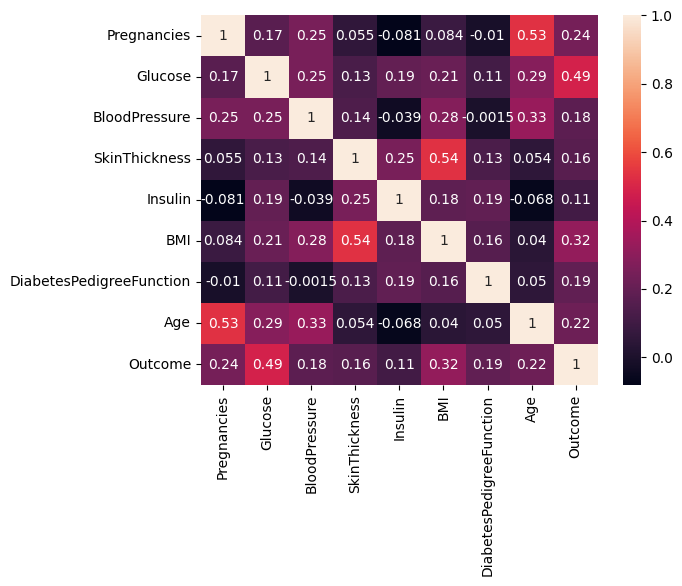

In [0]:
# Plot a heatmap to check correlations of features

vector_col = "corr_features"
assembler = VectorAssembler(inputCols=cols, 
                            outputCol=vector_col)
sdf_vector = assembler.transform(sdf).select(vector_col)
matrix = Correlation.corr(sdf_vector, vector_col).collect()[0][0]
corrmatrix = matrix.toArray().tolist()
#display(corrmatrix)

# Plot the heat map with the correlation matrix derived above
sns.heatmap(corrmatrix, annot=True, xticklabels=cols, yticklabels=cols)

From the heatmap, we can see that no two features have a good correlation with each other. Hence, we can consider all the features as the predictors for our model, with Outcome being the target. We can also see that Insulin has the least correlation with the target variable Outcome. Hence, we can henceforth omit it in the model training.

**4. Data Preparation**

4 a.	Do the final feature selection and extract them into Column X and the class label into Column into Y.

In [0]:
#Dropping features with least correlation with the target feature Outcome

sdf=sdf.drop('Insulin')#, 'SkinThickness', 'BloodPressure', 'DiabetesPedigreeFunction')
sdf.show(5)

+-----------+-------+-------------+-------------+----+------------------------+----+-------+
|Pregnancies|Glucose|BloodPressure|SkinThickness| BMI|DiabetesPedigreeFunction| Age|Outcome|
+-----------+-------+-------------+-------------+----+------------------------+----+-------+
|        6.0|  148.0|         72.0|         35.0|33.6|                   0.627|50.0|      1|
|        1.0|   85.0|         66.0|         29.0|26.6|                   0.351|31.0|      0|
|        8.0|  183.0|         64.0|         23.0|23.3|                   0.672|32.0|      1|
|        1.0|   89.0|         66.0|         23.0|28.1|                   0.167|21.0|      0|
|        3.0|  137.0|         40.0|         35.0|43.1|                   2.288|33.0|      1|
+-----------+-------+-------------+-------------+----+------------------------+----+-------+
only showing top 5 rows



Handling Imbalanced Dataset

When we visualised the dataset classes above, we found that around 35% people have diabetes. This shows that the dataset is imbalanced. To balance the dataset, we will oversample the minority class here. The minority class is Outcome=0.

In [0]:
# Split the dataset into minority and majority classes
minority_class = sdf.filter(F.col("Outcome") == 0)
majority_class = sdf.filter(F.col("Outcome") == 1)

# Calculate the ratio of minority to majority class
minority_count = minority_class.count()
majority_count = majority_class.count()
imbalance_ratio = majority_count / minority_count

# Oversampling the minority class to handle imbalanced dataset
oversampled_minority = minority_class.sample(True, imbalance_ratio, seed=42)
oversampled_dataset = oversampled_minority.unionAll(majority_class)

# Show the results
oversampled_dataset.groupBy("Outcome").count().show()
sdf=oversampled_dataset


display(sdf)

+-------+-----+
|Outcome|count|
+-------+-----+
|      0|  265|
|      1|  240|
+-------+-----+



Pregnancies,Glucose,BloodPressure,SkinThickness,BMI,DiabetesPedigreeFunction,Age,Outcome
10.0,139.0,80.0,23.0,27.1,1.441,57.0,0
1.0,103.0,30.0,38.0,43.3,0.183,33.0,0
3.0,126.0,88.0,41.0,39.3,0.704,27.0,0
5.0,109.0,75.0,26.0,36.0,0.546,60.0,0
6.0,92.0,92.0,23.0,19.9,0.188,28.0,0
10.0,122.0,78.0,31.0,27.6,0.512,45.0,0
3.0,180.0,64.0,25.0,34.0,0.271,26.0,0
7.0,133.0,84.0,23.0,40.2,0.696,37.0,0
7.0,133.0,84.0,23.0,40.2,0.696,37.0,0
7.0,106.0,92.0,18.0,22.7,0.235,48.0,0


4 b.	Split the dataset into training and test sets.

In [0]:
#Splitting the dataset into train set and test set

predictor_cols= [col for col in sdf.columns if col != 'Outcome']
target_col= 'Outcome'

# Assemble the features into a single vector column
assembler = VectorAssembler(inputCols=predictor_cols, outputCol='features')
assembled_df = assembler.transform(sdf)
assembled_df.show(5, truncate=False)


# Split the dataset into training and test sets
train_data, test_data = assembled_df.randomSplit([0.8, 0.2], seed=42)

print("Training Dataset Count: " + str(train_data.count()))
print("Test Dataset Count: " + str(test_data.count()))

+-----------+-------+-------------+-------------+----+------------------------+----+-------+--------------------------------------+
|Pregnancies|Glucose|BloodPressure|SkinThickness|BMI |DiabetesPedigreeFunction|Age |Outcome|features                              |
+-----------+-------+-------------+-------------+----+------------------------+----+-------+--------------------------------------+
|10.0       |139.0  |80.0         |23.0         |27.1|1.441                   |57.0|0      |[10.0,139.0,80.0,23.0,27.1,1.441,57.0]|
|1.0        |103.0  |30.0         |38.0         |43.3|0.183                   |33.0|0      |[1.0,103.0,30.0,38.0,43.3,0.183,33.0] |
|3.0        |126.0  |88.0         |41.0         |39.3|0.704                   |27.0|0      |[3.0,126.0,88.0,41.0,39.3,0.704,27.0] |
|5.0        |109.0  |75.0         |26.0         |36.0|0.546                   |60.0|0      |[5.0,109.0,75.0,26.0,36.0,0.546,60.0] |
|6.0        |92.0   |92.0         |23.0         |19.9|0.188                 

**5. Model Building**

i. Logistic Regression:

Logistic Regression is a simple and widely used algorithm for binary classification.
It models the probability that a given input belongs to a certain class using a logistic function.
It's relatively fast and interpretable, making it a good choice for small datasets.

In [0]:
# Create a Logistic Regression model
lr = LogisticRegression(featuresCol = 'features', labelCol = 'Outcome', maxIter=10)

# Train the model
lr_model = lr.fit(train_data)

# Make predictions
lr_predictions = lr_model.transform(test_data)

ii. Random Forest classifier

Random Forest Classifier is an ensemble learning method that constructs a multitude of decision trees during training and outputs the class that is the mode of the classes (for classification) or mean prediction (for regression) of the individual trees. It is effective in binary classification tasks with small datasets as it reduces overfitting by averaging predictions across multiple decision trees, which helps to generalize well to unseen data and mitigate the risk of bias from limited sample size. 

In [0]:
# Create a Random Forest Classifier model
rf = RandomForestClassifier(featuresCol='features', labelCol='Outcome')

# Train the model
rf_model = rf.fit(train_data)

# Make predictions
rf_predictions = rf_model.transform(test_data)

iii. Naive Bayes Classifier

Naive Bayes classifier is based on the assumption of independence between features. It is commonly used for text classification tasks due to its simplicity and efficiency. I can perform well on small datasets, making it suitable for binary classification tasks with limited training examples. However, its performance may degrade if the independence assumption is violated or if features are highly correlated.

In [0]:
# Create a Naive Bayes Classification model
nb = NaiveBayes(featuresCol='features', labelCol='Outcome')

# Train the model
nb_model = nb.fit(train_data)

# Make predictions
nb_predictions = nb_model.transform(test_data)

iv. Gradient Boost Classifier

In [0]:
# Create a Gradient Boost Classifier model
gbt = GBTClassifier(labelCol=target_col, featuresCol="features")

# Train the model
gbt_model = gbt.fit(train_data)

# Make predictions
gbt_predictions = gbt_model.transform(test_data)

**6.	Performance Evaluation**

In [0]:
def model_evaluation(predictions, classifier_name):

	# Create a SparkSession
	spark = SparkSession.builder \
	.appName("ModelEvaluation") \
	.getOrCreate()

	# Evaluate model using BinaryClassificationEvaluator 
 	# to get AUC-ROC (Area Under the Receiver Operating Characteristic Curve)
	# The higher the AUC, the better the model's performance at distinguishing between the positive and negative classes.
	evaluator = BinaryClassificationEvaluator(labelCol=target_column)
	auc = evaluator.evaluate(predictions)

	print(classifier_name+"\n------------------------------\n")
	print("AUC-ROC: ", auc)
	
	# Evaluate model using MulticlassClassificationEvaluator to get accuracy metrics
	evaluator = MulticlassClassificationEvaluator(labelCol=target_column, predictionCol="prediction")
	accuracy = evaluator.evaluate(predictions, {evaluator.metricName: "accuracy"})
	precision = evaluator.evaluate(predictions, {evaluator.metricName: "weightedPrecision"})
	recall = evaluator.evaluate(predictions, {evaluator.metricName: "weightedRecall"})
	f1_score = evaluator.evaluate(predictions, {evaluator.metricName: "f1"})

	# Compute confusion matrix
	# Select only prediction and label columns
	# Important: need to cast to float type, and order by prediction, else it won't work
	predictionAndLabels = predictions.select(['prediction',target_column]).withColumn('label', F.col(target_column).cast(FloatType())).orderBy('prediction')
	predictionAndLabels = predictionAndLabels.select(['prediction','label'])
	metrics = MulticlassMetrics(predictionAndLabels.rdd.map(tuple))
	confusion_matrix = metrics.confusionMatrix().toArray()

	# Print classification report
	print('Classification Report:')
	print(f"Accuracy: {accuracy}")
	print(f"Precision: {precision}")
	print(f"Recall: {recall}")
	print(f"F1 Score: {f1_score}")
 
    # 6a. Print the confusion matrix
	print("\nConfusion Matrix: ")
	print(confusion_matrix)
 
    # 6b. Display results for inference
	print("Prediction Results:")
	predictions.select("features", target_col, "prediction").show()

In [0]:
# Evaluate Logistic Regression Model
model_evaluation(lr_predictions, "Logistic Regression Model")

Logistic Regression Model
------------------------------

AUC-ROC:  0.7801136363636364


/databricks/spark/python/pyspark/sql/context.py:165: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


Classification Report:
Accuracy: 0.6309523809523809
Precision: 0.6410106899902819
Recall: 0.6309523809523809
F1 Score: 0.6285903922086541

Confusion Matrix: 
[[29. 11.]
 [20. 24.]]
Prediction Results:
+--------------------+-------+----------+
|            features|Outcome|prediction|
+--------------------+-------+----------+
|[1.0,79.0,80.0,25...|      0|       0.0|
|[1.0,87.0,60.0,37...|      0|       0.0|
|[1.0,87.0,78.0,27...|      0|       0.0|
|[1.0,91.0,54.0,25...|      0|       0.0|
|[1.0,97.0,70.0,15...|      0|       0.0|
|[1.0,99.0,58.0,10...|      0|       0.0|
|[1.0,103.0,30.0,3...|      0|       1.0|
|[1.0,109.0,58.0,1...|      0|       0.0|
|[1.0,116.0,78.0,2...|      0|       0.0|
|[1.0,116.0,78.0,2...|      0|       0.0|
|[1.0,119.0,54.0,1...|      0|       0.0|
|[1.0,121.0,78.0,3...|      0|       0.0|
|[1.0,124.0,74.0,3...|      0|       0.0|
|[1.0,139.0,46.0,1...|      0|       0.0|
|[2.0,85.0,65.0,23...|      0|       0.0|
|[2.0,92.0,76.0,20...|      0|       0.0|
|


Precision: 64% is a good indication that the model isn't making many positive predictions for negative cases (low false positive rate).

Recall: Recall (63%) reflects how well the model identifies true positive cases. Here, it means the model identified 63%% of the actual positive cases.  This is a more important metric for the minority class (oversampled here),  because missing true positives can be costly.

Considering the class imbalance addressed through oversampling, it's important to prioritize identifying true positive cases (high recall).  Here, the model performs well in this aspect. The trade-off is a slightly lower precision, meaning the model might generate some false positives (predicting positive for negative cases). However, the F1-score gives an overall balanced assessment, indicating an acceptable model performance. 

We also have to rely on AUC for an evaluation metric here. AUC of 0.78 also indicates an acceptable model performance.

In [0]:
# Evaluate Random Forest Classifier Model
model_evaluation(rf_predictions, "Random Forest Classifier Model")

Random Forest Classifier Model
------------------------------

AUC-ROC:  0.8153409090909091
Classification Report:
Accuracy: 0.7023809523809523
Precision: 0.7044269778245955
Recall: 0.7023809523809523
F1 Score: 0.7025075090277074

Confusion Matrix: 
[[29. 11.]
 [14. 30.]]
Prediction Results:
+--------------------+-------+----------+
|            features|Outcome|prediction|
+--------------------+-------+----------+
|[1.0,79.0,80.0,25...|      0|       0.0|
|[1.0,87.0,60.0,37...|      0|       0.0|
|[1.0,87.0,78.0,27...|      0|       0.0|
|[1.0,91.0,54.0,25...|      0|       0.0|
|[1.0,97.0,70.0,15...|      0|       0.0|
|[1.0,99.0,58.0,10...|      0|       0.0|
|[1.0,103.0,30.0,3...|      0|       1.0|
|[1.0,109.0,58.0,1...|      0|       0.0|
|[1.0,116.0,78.0,2...|      0|       0.0|
|[1.0,116.0,78.0,2...|      0|       0.0|
|[1.0,119.0,54.0,1...|      0|       0.0|
|[1.0,121.0,78.0,3...|      0|       0.0|
|[1.0,124.0,74.0,3...|      0|       0.0|
|[1.0,139.0,46.0,1...|      0|     

Precision: Precision (0.70) indicates that out of all the instances the model predicted as positive, 70% were actually positive. This is a good sign,  showing the model isn't making many positive predictions for negative cases (low false positive rate).

Recall: Recall (0.70) means the model identified 70% of the actual positive cases. This is a good result, especially for the minority class (oversampled here),  because missing true positives can be costly.

Considering the AUC 0.81 of this model, this model has a moderately good performance.

In [0]:
# Evaluate Naive Bayes Classifier Model
model_evaluation(nb_predictions, "Naive Bayes Classifier Model")

Naive Bayes Classifier Model
------------------------------

AUC-ROC:  0.24829545454545457
Classification Report:
Accuracy: 0.6785714285714286
Precision: 0.6956115779645191
Recall: 0.6785714285714286
F1 Score: 0.6750392464678179

Confusion Matrix: 
[[32.  8.]
 [19. 25.]]
Prediction Results:
+--------------------+-------+----------+
|            features|Outcome|prediction|
+--------------------+-------+----------+
|[1.0,79.0,80.0,25...|      0|       0.0|
|[1.0,87.0,60.0,37...|      0|       0.0|
|[1.0,87.0,78.0,27...|      0|       0.0|
|[1.0,91.0,54.0,25...|      0|       0.0|
|[1.0,97.0,70.0,15...|      0|       0.0|
|[1.0,99.0,58.0,10...|      0|       0.0|
|[1.0,103.0,30.0,3...|      0|       1.0|
|[1.0,109.0,58.0,1...|      0|       1.0|
|[1.0,116.0,78.0,2...|      0|       0.0|
|[1.0,116.0,78.0,2...|      0|       0.0|
|[1.0,119.0,54.0,1...|      0|       1.0|
|[1.0,121.0,78.0,3...|      0|       0.0|
|[1.0,124.0,74.0,3...|      0|       0.0|
|[1.0,139.0,46.0,1...|      0|      

It's important to prioritize identifying true positive cases when someone has diabetes(high recall). Here, the Naive Bayes model's performance is weaker in recall (0.67) compared to precision (0.69). This suggests the model might be overly cautious in predicting positives, potentially missing some true positive cases (false negatives).

Even though the accuracy is 67%, the AUC is just 0.25, which suggests that Naive Bayes is likely to be a bad fit.

In [0]:
# Evaluate Gradient Boost Classifier Model
model_evaluation(gbt_predictions, "Gradient Boost Classifier Model")

Gradient Boost Classifier Model
------------------------------

AUC-ROC:  0.7619318181818182
Classification Report:
Accuracy: 0.7142857142857143
Precision: 0.7248677248677249
Recall: 0.7142857142857142
F1 Score: 0.712987012987013

Confusion Matrix: 
[[32.  8.]
 [16. 28.]]
Prediction Results:
+--------------------+-------+----------+
|            features|Outcome|prediction|
+--------------------+-------+----------+
|[1.0,79.0,80.0,25...|      0|       0.0|
|[1.0,87.0,60.0,37...|      0|       0.0|
|[1.0,87.0,78.0,27...|      0|       0.0|
|[1.0,91.0,54.0,25...|      0|       0.0|
|[1.0,97.0,70.0,15...|      0|       0.0|
|[1.0,99.0,58.0,10...|      0|       0.0|
|[1.0,103.0,30.0,3...|      0|       1.0|
|[1.0,109.0,58.0,1...|      0|       0.0|
|[1.0,116.0,78.0,2...|      0|       0.0|
|[1.0,116.0,78.0,2...|      0|       0.0|
|[1.0,119.0,54.0,1...|      0|       0.0|
|[1.0,121.0,78.0,3...|      0|       0.0|
|[1.0,124.0,74.0,3...|      0|       0.0|
|[1.0,139.0,46.0,1...|      0|     

Precision: Precision (0.72) tells us that out of all the instances the model predicted as positive, 72% were actually positive. This is a good indication that the Gradient Boosting Classifier is performing well in terms of making precise positive predictions (low false positive rate).

Recall: Recall (0.71) reflects how well the model identified 71% of the actual positive cases.  This is an acceptable recall.

The Gradient Boosting Classifier shows promising results with a good F1-score (0.71) and balanced precision-recall. This indicates the model is performing well on this classification task.